Боле́знь Паркинсо́на (синонимы: идиопатический синдром паркинсонизма, дрожательный паралич) — медленно прогрессирующее хроническое нейродегенеративное неврологическое заболевание, характерное для лиц старшей возрастной группы. Относится к дегенеративным заболеваниям экстрапирамидной моторной системы. Вызвано прогрессирующим разрушением и гибелью нейронов, вырабатывающих нейромедиатор дофамин, — прежде всего в чёрной субстанции, а также и в других отделах центральной нервной системы. Недостаточная выработка дофамина ведёт к тормозному влиянию базальных ганглиев на кору головного мозга.

Современная медицина пока не может излечить это заболевание, однако существующие методы консервативного и оперативного лечения позволяют значительно улучшить качество жизни больных и замедлить прогрессирование болезни

### Задача

Датасет состоит из медицинских показаний

Расшифровка обозначений используемых для названий столбцов:  
name - ASCII subject name and recording number  
MDVP:Fo(Hz) - Average vocal fundamental frequency  
MDVP:Fhi(Hz) - Maximum vocal fundamental frequency  
MDVP:Flo(Hz) - Minimum vocal fundamental frequency  
MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several
measures of variation in fundamental frequency  
MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude  
NHR,HNR - Two measures of ratio of noise to tonal components in the voice  
status - Health status of the subject (one) - Parkinson's, (zero) - healthy 
RPDE,D2 - Two nonlinear dynamical complexity measures  
DFA - Signal fractal scaling exponent  
spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation  

In [46]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np 
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
%matplotlib inline

In [47]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.simplefilter(action='ignore')

## Анализ данных

In [4]:
data = pd.read_csv("parkinsons.data")

In [5]:
data.shape

(195, 24)

In [6]:
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [8]:
data.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


Целевой признак **Status**

1 - болен  
0 - здоров  

In [9]:
data.describe()['status']

count    195.000000
mean       0.753846
std        0.431878
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: status, dtype: float64

Несбалансированная выборка: 0.75 в пользу больных

Отобразим попарную корреляцию признаков отсортированных по убыванию по величене корреляции с целевым признаком

<AxesSubplot:>

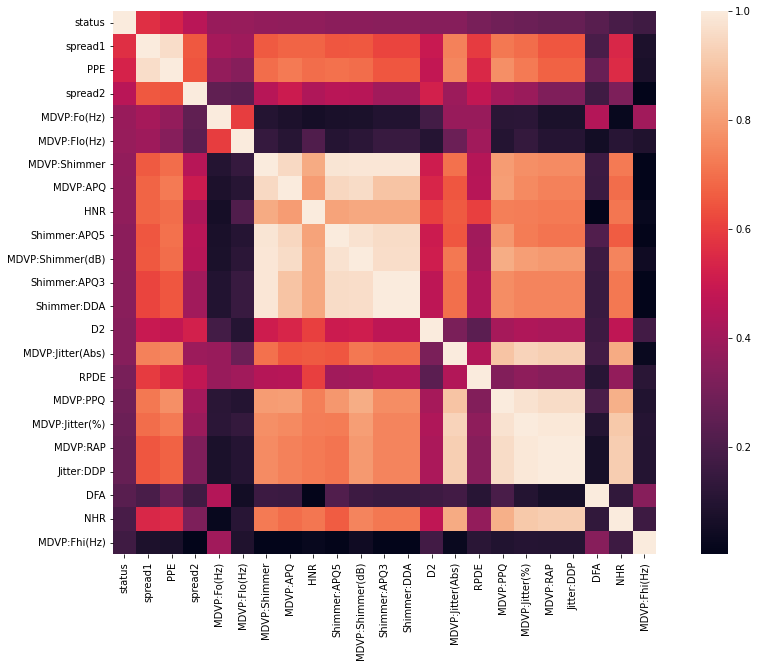

In [10]:
data_correlation = data.corr().abs()
ordered_columns=data_correlation.nlargest(len(data.columns),'status')['status'].index

plt.figure(figsize=(16,10))
sb.heatmap(data[ordered_columns].corr().abs(), square=True)

Можно сделать вывод, что есть признаки, которые сильно коррелируют друг с другом.

Рассмотрим коррелирующие между собой признаки

In [11]:
hi_corr_vals = data_correlation.unstack().where(lambda x: (x>0.8) & (x<1)).dropna().drop_duplicates().unstack()
hi_corr_vals.columns

Index(['MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer(dB)', 'NHR', 'MDVP:APQ', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:DDA', 'HNR', 'PPE'],
      dtype='object')

<AxesSubplot:>

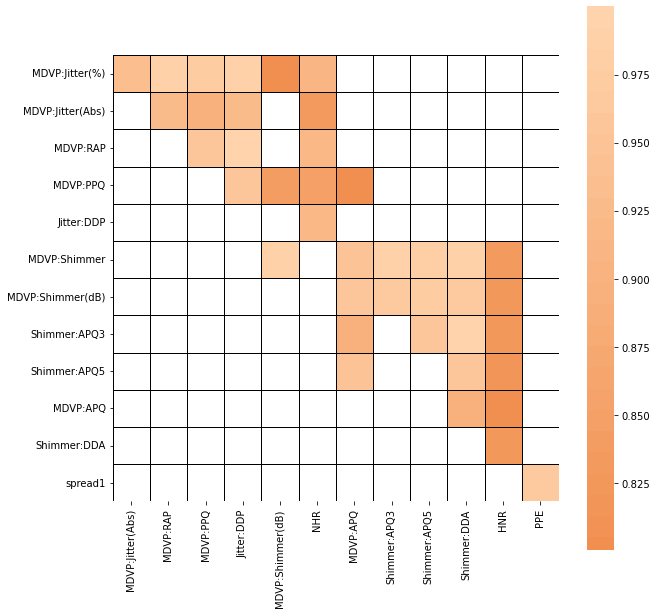

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
sb.heatmap(hi_corr_vals, center=0, square=True, linewidths=0.5, linecolor='black', ax=ax)

Из описания датасета признаки описывают изменчивость амплитуды голоса и коррелируют между собой:  
MDVP:Shimmer, MDVP:Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, MDVP:APQ, Shimmer:DDA.  
Заметим, что эти признаки коррелируют и с признаком HNR.

Удалим их за исключением MDVP:Shimmer.

In [13]:
dropped_shimmer_columns = ['MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'HNR']

Можно заметить, что метрики изменчивости основных частот голоса также коррелируют друг с другом  
MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, MDVP:PPQ, Jitter:DDP  

Также MDVP:Jitter(%) коррелирует с NHR.  
Оставим MDVP:Jitter(%)

In [14]:
dropped_jitter_columns = ['MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'NHR']

In [15]:
drop_corr_columns = dropped_shimmer_columns + dropped_jitter_columns

In [16]:
# Корреляция с целевым признаком
data.drop(drop_corr_columns, axis=1).corr().sort_values(by='status', ascending=False)['status']

status            1.000000
spread1           0.564838
PPE               0.531039
spread2           0.454842
MDVP:Shimmer      0.367430
D2                0.340232
RPDE              0.308567
MDVP:Jitter(%)    0.278220
DFA               0.231739
MDVP:Fhi(Hz)     -0.166136
MDVP:Flo(Hz)     -0.380200
MDVP:Fo(Hz)      -0.383535
Name: status, dtype: float64

In [17]:
labels = data.status
X = data.drop(drop_corr_columns + ['status', 'name'], axis=1)

In [18]:
X_labeled = data.drop(drop_corr_columns + ['name'], axis=1)

ValueError: num must be 1 <= num <= 10, not 11

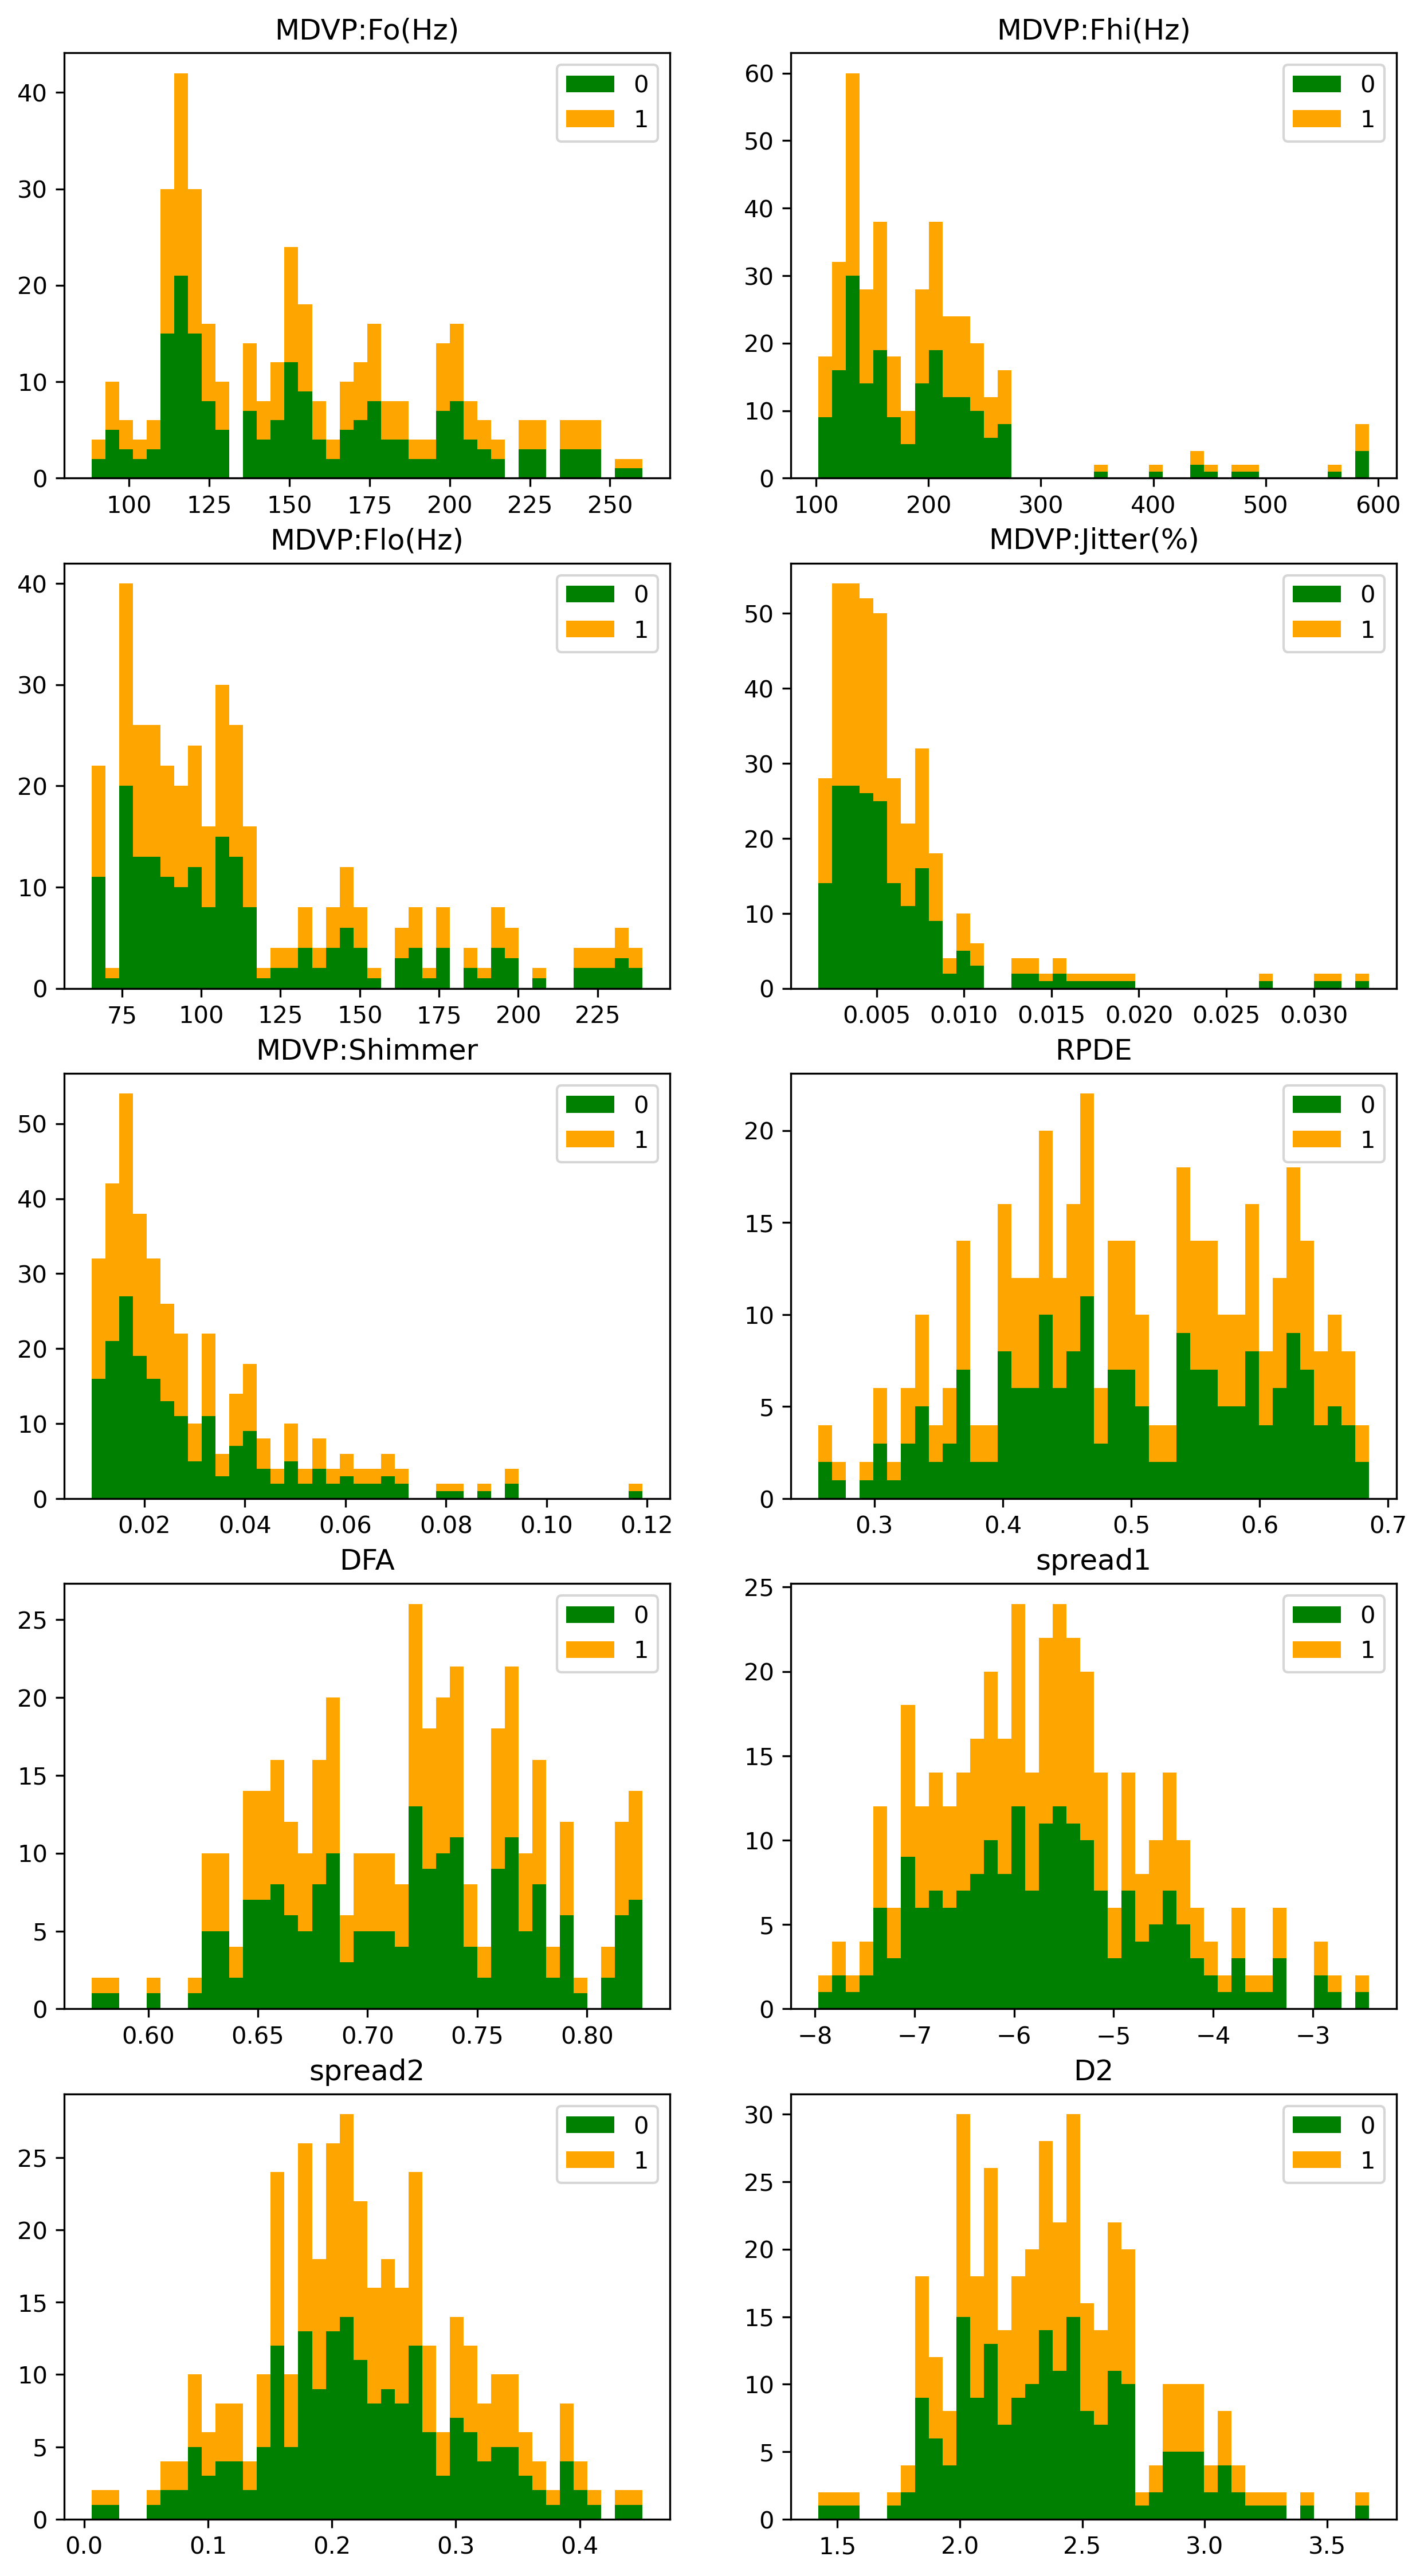

In [19]:
plt.figure(figsize=(10,19), dpi=300)

groupby_var = 'status'
for i, col in enumerate(X.columns, start=0):
    
    df_agg = data.loc[:, [col, groupby_var]].groupby(groupby_var)
    vals = [data[col].values.tolist() for i, df in df_agg]

    plt.subplot(5, 2, i+1)
    colors = ['green','orange']
    n, bins, patches = plt.hist(vals, 40, stacked=True, density=False, color=colors[:len(vals)])

    plt.legend({group:col for group, col in zip(np.unique(data[groupby_var]).tolist(), colors[:len(vals)])})
    plt.title(col)
    #plt.xticks(ticks=bins[::3], labels=[round(b,1) for b in bins[::3]])

По рисунку X видно, что выбросы имеются. В удаленных точках количество больных примерно равно количеству здоровых. Предположительно, удаление таких выбросов не должно отрицательно повлиять на качество модели.

In [20]:
X_cleared = X_labeled[X_labeled['MDVP:Jitter(%)']<0.025 ]
X_cleared['MDVP:Jitter(%)'] = np.log(X_cleared['MDVP:Jitter(%)'])

X_cleared['MDVP:Fo(Hz)'] = np.log(X_cleared['MDVP:Fo(Hz)'])
X_cleared['MDVP:Flo(Hz)'] = np.log(X_cleared['MDVP:Flo(Hz)'])
X_cleared['MDVP:Fhi(Hz)'] = np.log(X_cleared['MDVP:Fhi(Hz)'])

label_clr = X_cleared.status
X_cleared = X_cleared.drop('status', axis=1)

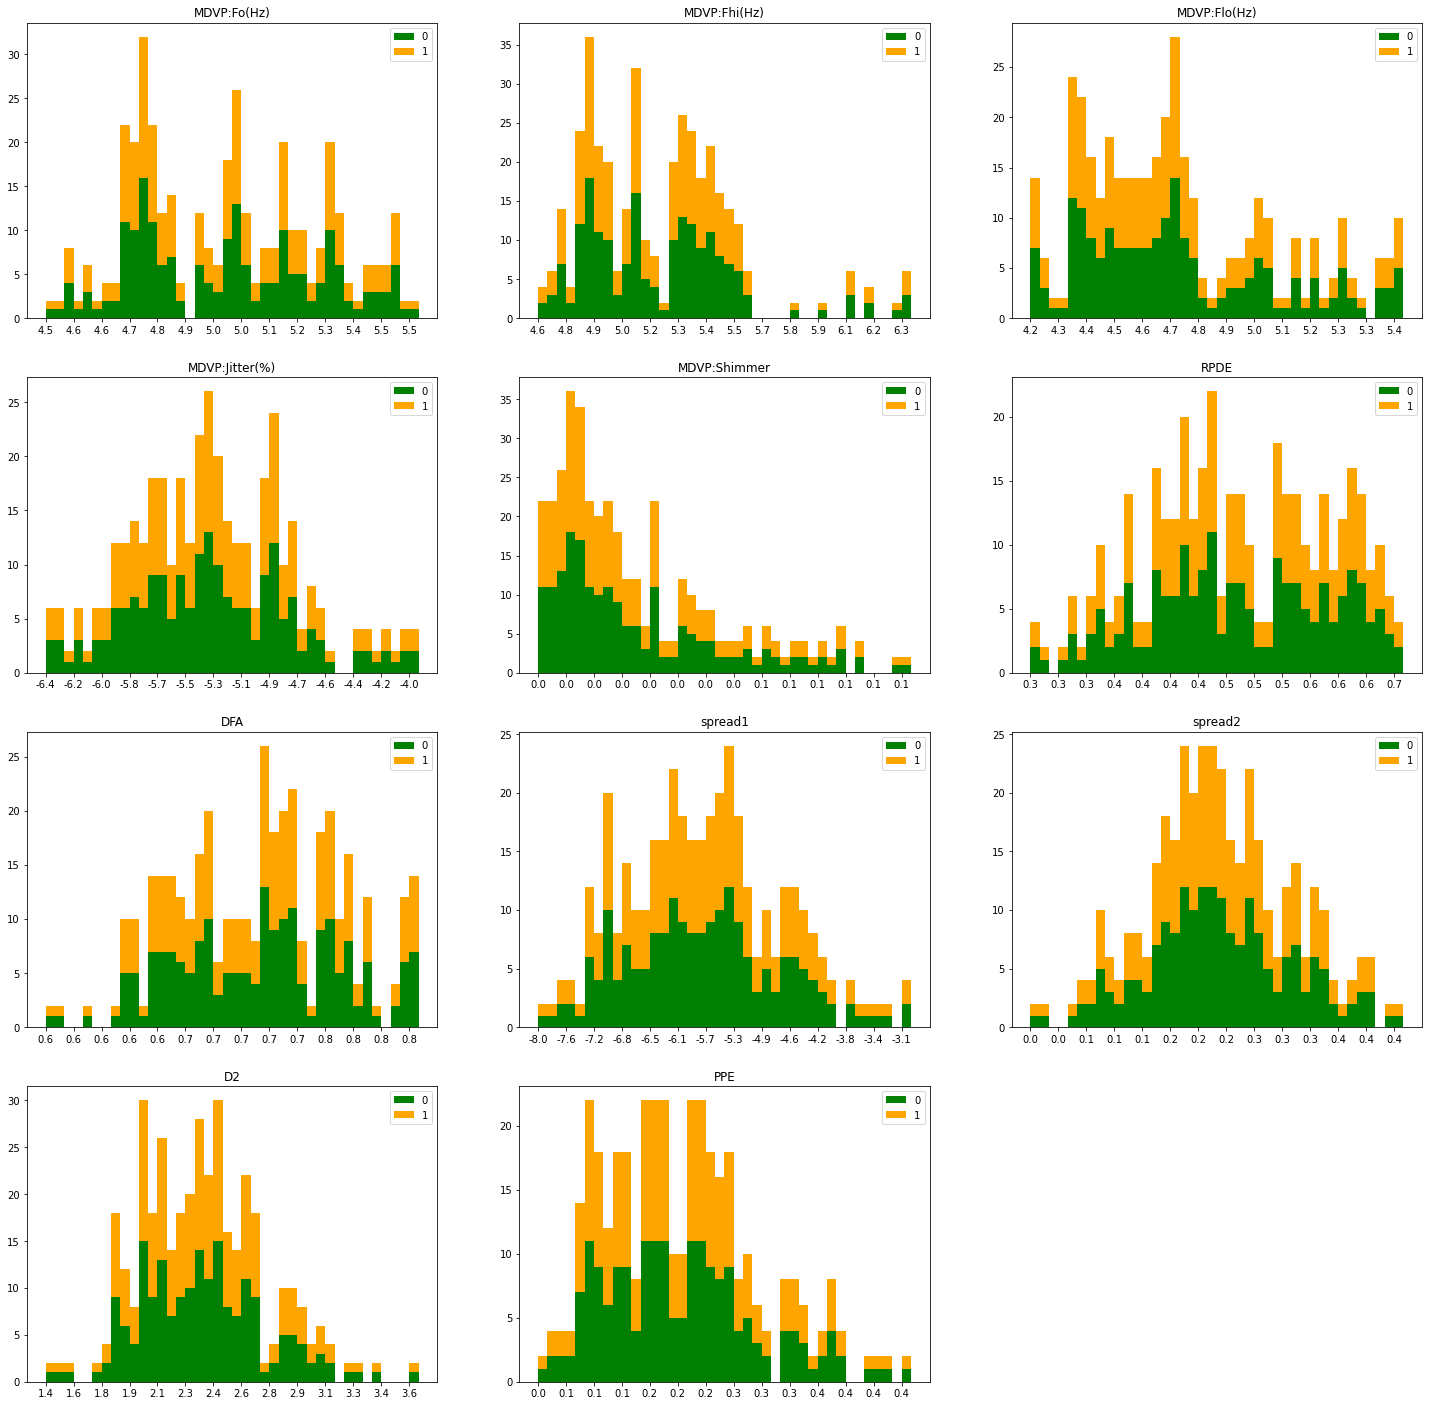

In [21]:
plt.figure(figsize=(25,25))

groupby_var = 'status'
for i, col in enumerate(X.columns, start=0):
    
    df_agg = data.loc[:, [col, groupby_var]].groupby(groupby_var)
    vals = [X_cleared[col].values.tolist() for i, df in df_agg]

    plt.subplot(4, 3, i+1)
    colors = ['green','orange']
    n, bins, patches = plt.hist(vals, 40, stacked=True, density=False, color=colors[:len(vals)])

    plt.legend({group:col for group, col in zip(np.unique(data[groupby_var]).tolist(), colors[:len(vals)])})
    plt.title(col)
    plt.xticks(ticks=bins[::3], labels=[round(b,1) for b in bins[::3]])

In [22]:
def modify_data(data):
    X = data.drop(drop_corr_columns + ['name'], axis=1)
    X['MDVP:Jitter(%)'] = np.log(data['MDVP:Jitter(%)'])
    X['MDVP:Fo(Hz)'] = np.log(data['MDVP:Fo(Hz)'])
    X['MDVP:Flo(Hz)'] = np.log(X['MDVP:Flo(Hz)'])
    X['MDVP:Fhi(Hz)'] = np.log(X['MDVP:Fhi(Hz)'])
    return X

### Модель логистической регрессии 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data, data.status, train_size=0.7, random_state=5,shuffle=True, stratify=data.status)

X_train_m = modify_data(X_train[X_train['MDVP:Jitter(%)']<0.025 ])
y_train_m = X_train_m.status
X_train_m = X_train_m.drop('status',axis=1)

X_test_m = modify_data(X_test.drop('status',axis=1))

In [24]:
sm.stats.ttest_ind

<function statsmodels.stats.weightstats.ttest_ind(x1, x2, alternative='two-sided', usevar='pooled', weights=(None, None), value=0)>

In [25]:
model_lgr = LogisticRegression(random_state=0)
model_lgr.fit(X_train_m, y_train_m)

print("accuracy = %f" % accuracy_score(model_lgr.predict(X_test_m), y_test))
print("precision = %f" % precision_score(model_lgr.predict(X_test_m), y_test))
print("recall = %f" % recall_score(model_lgr.predict(X_test_m), y_test))
print("roc_auc = %f" % roc_auc_score(model_lgr.predict(X_test_m), y_test))

accuracy = 0.830508
precision = 0.977273
recall = 0.826923
roc_auc = 0.842033


In [26]:
featureImportance = pd.DataFrame(
    {'feature': [X_train_m.columns[i] for i in range(len(X_train_m.columns))], 'coef': np.round(model_lgr.coef_[0],4)}
)
featureImportance = featureImportance.sort_values(by='coef', ascending=False)

featureImportance.to_csv('feature_importance1.csv')

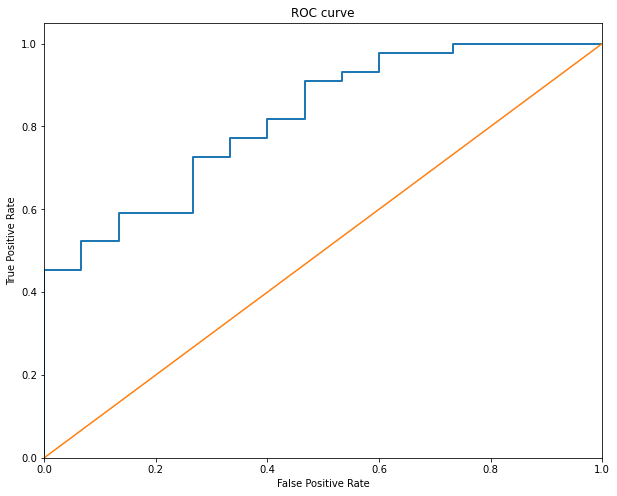

In [27]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, model_lgr.predict_proba(X_test_m)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

----

### Модель XGBoost

In [29]:
model_XGB = XGBClassifier(random_state=0, seed=1337)
model_XGB.fit(X_train_m, y_train_m)

print("accuracy = %f" % accuracy_score(model_XGB.predict(X_test_m), y_test))
print("precision = %f" % precision_score(model_XGB.predict(X_test_m), y_test))
print("recall = %f" % recall_score(model_XGB.predict(X_test_m), y_test))
print("roc_auc = %f" % roc_auc_score(model_XGB.predict(X_test_m), y_test))

accuracy = 0.864407
precision = 0.977273
recall = 0.860000
roc_auc = 0.874444


In [30]:
model_XGB.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'seed': 1337}

In [31]:
parameters = {
    'objective':        ['binary:logistic'],
    'learning_rate':    [0.2, 0.1, 0.05, 0.03, 0.001],
    'max_depth':        [4, 6, 8, 10],
    'min_child_weight': [1, 5, 11],
    'subsample':        [0.5, 0.8],
    'n_estimators':     [10, 30, 40, 50, 100, 200, 400, 600],
    'seed':             [1337],
    'scoring':          ['roc_auc', 'recall']
}

In [32]:
xgb_model =  XGBClassifier(random_state=0)
clf = GridSearchCV(xgb_model, 
                   parameters, 
                   n_jobs=10, 
                   cv=StratifiedKFold(n_splits=2,
                                      random_state=0,
                                      shuffle=True),
                   verbose=2, 
                   refit=True)

clf.fit(X_train_m, y_train_m)

Fitting 2 folds for each of 1920 candidates, totalling 3840 fits
[06:36:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=0, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_c...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.2, 0.1, 0.05, 0.03, 0.001],
                  

In [33]:
best_XGB_model = clf.best_estimator_
best_XGB_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.2,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 4,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 30,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'scoring': 'roc_auc',
 'seed': 1337}

In [35]:
print("accuracy_score  = %.4f" % accuracy_score(best_XGB_model.predict(X_test_m), y_test))
print("precision_score  = %.4f" % precision_score(best_XGB_model.predict(X_test_m), y_test))
print("recall_score  = %.4f" % recall_score(best_XGB_model.predict(X_test_m), y_test))
print("roc_auc_score  = %.4f" % roc_auc_score(best_XGB_model.predict(X_test_m), y_test))

accuracy_score  = 0.8475
precision_score  = 0.9773
recall_score  = 0.8431
roc_auc_score  = 0.8591


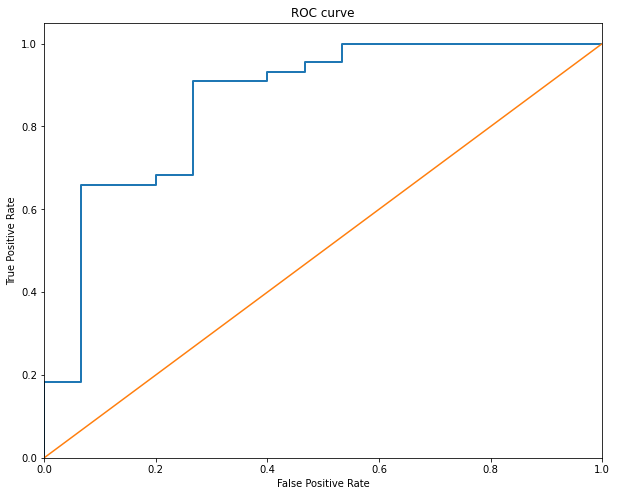

In [36]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, best_XGB_model.predict_proba(X_test_m)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [37]:

featureImportance = pd.DataFrame(
    {'feature': [X_cleared.columns[i] for i in range(len(X_cleared.columns))], 'coef': np.round(best_XGB_model.feature_importances_,4)}
)
featureImportance = featureImportance.sort_values(by='coef', ascending=False)
featureImportance.to_csv('feature_importanceXGB.csv')

In [38]:
featureImportance

,feature,coef
7,spread1,0.2483
10,PPE,0.1638
3,MDVP:Jitter(%),0.1470
4,MDVP:Shimmer,0.1028
0,MDVP:Fo(Hz),0.0644
2,MDVP:Flo(Hz),0.0562
1,MDVP:Fhi(Hz),0.0555
9,D2,0.0466
8,spread2,0.0408
6,DFA,0.0386


In [39]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('name',axis=1), data.status, train_size=0.7, random_state=5,shuffle=True, stratify=data.status)

X_train_m = X_train[X_train['MDVP:Jitter(%)']<0.025]
y_train_m = X_train_m.status
X_train_m = X_train_m.drop('status',axis=1)

X_test_m = X_test.drop('status',axis=1)

In [40]:
parameters = {
    'objective':        ['binary:logistic'],
    'learning_rate':    [0.2, 0.1, 0.05, 0.03, 0.001],
    'max_depth':        [4, 6, 8, 10],
    'min_child_weight': [1, 5, 11],
    'subsample':        [0.5, 0.8],
    'n_estimators':     [10, 30, 40, 50, 100, 200, 400, 600],
    'seed':             [1337],
    'scoring':          ['roc_auc', 'recall']
}

In [41]:
xgb_model =  XGBClassifier(random_state=0)
clf = GridSearchCV(xgb_model, 
                   parameters, 
                   n_jobs=10, 
                   cv=StratifiedKFold(n_splits=2,
                                      random_state=0,
                                      shuffle=True),
                   verbose=2, 
                   refit=True)

clf.fit(X_train_m, y_train_m)

Fitting 2 folds for each of 1920 candidates, totalling 3840 fits
[06:37:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=0, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_c...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.2, 0.1, 0.05, 0.03, 0.001],
                  

In [42]:
print("accuracy_score  = %.4f" % accuracy_score(clf.best_estimator_.predict(X_test_m), y_test))
print("precision_score  = %.4f" % precision_score(clf.best_estimator_.predict(X_test_m), y_test))
print("recall_score  = %.4f" % recall_score(clf.best_estimator_.predict(X_test_m), y_test))
print("roc_auc_score  = %.4f" % roc_auc_score(clf.best_estimator_.predict(X_test_m), y_test))

accuracy_score  = 0.8475
precision_score  = 1.0000
recall_score  = 0.8302
roc_auc_score  = 0.9151
